# Laboratorio 4. Práctica 1 - Algoritmo Genético con mutaciones
## Preparación de entorno
### Gonzalo de las Heras
### Jorge de la Fuente

#### Importar librerías de código

In [809]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import random
import sys

from math import e
from time import time

#### Parámetros del algoritmo genérico

In [810]:
Target = "ANIMULA VAGULA BLANDULA" 
NPOB = 120
NGEN = 3000
Q = 0.99
NRES = 25
NSAMPLE = 50

if NPOB % 4 != 0:
    sys.exit("Error: La población no es múltiplo de 4.")

In [811]:
# No tocar
ITAR_TARGET = len(Target)
T_Inicio = 0
T_Final = 0
T_TOTAL = 0
Parada = 0
Terminar_Evolucion = 0

Stats_num_coincidencias_max = np.zeros(1) 
Stats_num_coincidencias_max_porcentaje = np.zeros(1) 
Stats_num_coincidencias_medio = np.zeros(1)  
Stats_num_coincidencias_medio_porcentaje = np.zeros(1) 
Stats_num_targets = np.zeros(1) 
Stats_num_targets_porcentaje = np.zeros(1) 

#### Variables globales

In [812]:
Alfabeto = np.array(["A","B","C","D","E","F","G","H","I",
                     "J","K","L","M","N","Ñ","O","P","Q",
                     "R","S","T","U","V","W","X","Y","Z"," "])
Poblacion = None
Fitness = np.zeros(NPOB)
Coincidencias = np.zeros(NPOB)
Generacion_Actual = 1
Num_Coincidencias_Max = 0

#### Funciones auxiliares

In [813]:
def ImprimirPorcentajePoblacion():
    porcentaje = 20
    num_individuos_a_imprimir = int(round(20 * NPOB / 100, 0))
    posiciones_aleatoras = random.sample(range(0, NPOB - 1), num_individuos_a_imprimir)
    print("= Muestra de " + str(20) + "% de individuos (" + str(num_individuos_a_imprimir) + "):")
    print("=====================================")
    for i in range (0, num_individuos_a_imprimir):
        print("= #" + str(i + 1) + ": '" + ImprimirCromosoma(Poblacion[posiciones_aleatoras[i]]) + "'")

In [814]:
def ImprimirPoblacion():
    print("==================================================")
    for i in range(0, NPOB):
        print("#" + str(i) + ": '" + ImprimirCromosoma(Poblacion[i]) + "'")

In [815]:
def GenerarPoblacion():    
    # Números aleatorios
    poblacion_numeros = np.random.randint(0, len(Alfabeto), size=len(Target) * NPOB)
    
    # Creación del array de la poblacion con caracter "_"
    poblacion = np.array(['_' for _ in range(len(Target) * NPOB)])
    
    # Cambiamos los números por las letras del alfabeto
    for i in range(0, len(Target) * NPOB):
        letra = Alfabeto[poblacion_numeros[i]].encode('utf8', 'ignore').decode('utf8')
        poblacion[i] = letra
        
    # Devuelve la array de la población con el shape correcto
    return poblacion.reshape(NPOB, len(Target))

In [816]:
def GetLetraConsenso(PosicionLetra):
    letra = ''
    coincidencias = np.zeros(Alfabeto.shape[0])
    for i in range (0, Poblacion.shape[0]):
        coincidencias[np.where(Alfabeto == Poblacion[i][PosicionLetra])] += 1
    letra_index = np.argmax(coincidencias)
    letra = Alfabeto[letra_index]
    return letra

def GetIndividuoConsenso():
    individuo_consenso = ""
    for i in range(0, ITAR_TARGET):
        individuo_consenso += GetLetraConsenso(i)  
    return individuo_consenso

In [817]:
def CalcularFitnessFrase(Frase):
    num_coincidencias = 0
    
    # Recorremos toda la frase buscando coincidencias con la frase TARGET
    for i in range(0, ITAR_TARGET):
        if (Target[i] == Frase[i]):
            num_coincidencias += 1
            
    # Devuelve el fitness (sin normalizar) y el número de coincidencias
    return e**(num_coincidencias - ITAR_TARGET) - e **(-1 * ITAR_TARGET), num_coincidencias

In [818]:
def CalcularFitnessNormalizadoPoblacion():    
    # Cálculo del fitness    
    for i in range(0, NPOB):
        Fitness[i], Coincidencias[i] = CalcularFitnessFrase(Poblacion[i])
        
    # Cálculo del fitness normalizado    
    Num_Coincidencias_Max = np.max(Coincidencias)    
    
    for i in range(0, NPOB):
        Fitness[i] = Fitness[i] / (e**(Num_Coincidencias_Max - ITAR_TARGET) - e **(-1 * ITAR_TARGET))

In [819]:
def Replicar(Individuo, Posicion):    
    # Copiamos el cromosoma al nuevo individuo teniendo en cuenta el factor de calidad
    for i in range(0, ITAR_TARGET):
        if np.random.uniform(0, 1) > Q:
            # Mutación
            Poblacion[Posicion][i] = Alfabeto[np.random.randint(0, len(Alfabeto))]
        else:
            # Copia exacta
            Poblacion[Posicion][i] = Individuo[i]

In [820]:
def ImprimirCromosoma(Cromosoma):
    texto = ""
    for i in range(0, len(Cromosoma)):
        texto += Cromosoma[i]
    return texto

In [821]:
def GetCromosomasPerfectos():
    indices_cromosomas_perfectos = np.where(Coincidencias==ITAR_TARGET)[0]
    print("-----------------------------------------")
    print("- Cromosoma objetivo: (" + Target + ")")
    print("-----------------------------------------")
    print("- En la población hay (", len(indices_cromosomas_perfectos), ") individuos perfectos.")
    print("-----------------------------------------")
    print("- Son:")
    print("-----------------------------------------")   
    for i in range(0, len(indices_cromosomas_perfectos)):
        print("#", indices_cromosomas_perfectos[i], "Cromosoma: ")
        ImprimirCromosoma(Poblacion[indices_cromosomas_perfectos[i]])
        print("-----------------------------------------")   

In [822]:
def EvolucionarPoblacion():    
    padres = GetPadres()    
    padres_shape = padres.shape[0]
    for i in range(0, 4):
        for j in range(0, padres_shape):
            if i == 0:
                Poblacion[padres_shape*i+j] = padres[j]
            else:
                Replicar(Poblacion[j], padres_shape*i+j)
    
    CalcularFitnessNormalizadoPoblacion()

In [823]:
def GetPadres():
    # Cálculo del número de padres
    num_padres = int(round(25 * NPOB /100, 0))
    padres = np.array(['_' for _ in range(len(Target) * num_padres)])
    padres = padres.reshape(num_padres, len(Target))
    
    # Índices de los mejores individuos
    fitness_index = np.zeros(num_padres)
    
    for i in range(0, num_padres):
        mejor_individuo = np.argmax(Fitness)
        fitness_index[i] = mejor_individuo
        Fitness[mejor_individuo] = -1
        
    for i in range(0, num_padres):
        indice = int(fitness_index[i])
        padres[i] = Poblacion[indice]
        
    return padres

In [824]:
def ImprimirReporte(Generacion_Actual):
    
    global Stats_num_coincidencias_max
    global Stats_num_coincidencias_max_porcentaje
    
    global Stats_num_coincidencias_medio
    global Stats_num_coincidencias_medio_porcentaje
    
    global Stats_num_targets
    global Stats_num_targets_porcentaje
    
    num_coincidencias_max = int(round(np.max(Coincidencias), 0))
    num_coincidencias_max_porcentaje = int(round((num_coincidencias_max * 100) / ITAR_TARGET, 0))
    
    num_coincidencias_medio = int(round(np.mean(Coincidencias), 0))
    num_coincidencias_medio_porcentaje = int(round((num_coincidencias_medio * 100) / ITAR_TARGET, 0))   
                                        
    num_targets = len(np.where(Coincidencias==ITAR_TARGET)[0])
    num_targets_porcentaje = int(round((num_targets / NPOB) * 100, 0))
    
    Stats_num_coincidencias_max = np.append(Stats_num_coincidencias_max, num_coincidencias_max)
    Stats_num_coincidencias_max_porcentaje = np.append(Stats_num_coincidencias_max_porcentaje, num_coincidencias_max_porcentaje)
    
    Stats_num_coincidencias_medio = np.append(Stats_num_coincidencias_medio, num_coincidencias_medio)
    Stats_num_coincidencias_medio_porcentaje = np.append(Stats_num_coincidencias_medio_porcentaje, num_coincidencias_medio_porcentaje)
    
    Stats_num_targets = np.append(Stats_num_targets, num_targets)
    Stats_num_targets_porcentaje = np.append(Stats_num_targets_porcentaje, num_targets_porcentaje)   
    
    print("==================================================")
    print("= Target: '"+ Target+"'")
    print("= Longitud Target: ", ITAR_TARGET)
    print("= Longitud Poblacion: ", NPOB)
    print("= Número Generaciones: ", NGEN)
    print("= Factor de Calidad: ", Q)
    print("==================================================")
    print("= Generacion Actual: ", Generacion_Actual)
    print("= Mejor Individuo: '" + ImprimirCromosoma(Poblacion[np.argmax(Coincidencias)]) + "'")
    print("= Nº Coincidencias máximo: ", num_coincidencias_max, " - ", num_coincidencias_max_porcentaje, "%")
    print("= Nº Coincidencias medio: ", num_coincidencias_medio, " - ", num_coincidencias_medio_porcentaje, "%")
    print("= Nº Targets: ", num_targets, " - ", num_targets_porcentaje, "%") 
    print("==================================================")
    print("==================================================")
    print("\n")

In [825]:
def ComprobarCriterioDeParada(Terminar_Evolucion_Num):
    num_targets = len(np.where(Coincidencias==ITAR_TARGET)[0])
    num_targets_porcentaje = int(round((num_targets / NPOB) * 100, 0))   
    
    if num_targets_porcentaje >= 20:
        Terminar_Evolucion_Num += 1
    else:
        Terminar_Evolucion_Num = 0
    return Terminar_Evolucion_Num    

In [826]:
def ImprimirGraficas():
    plt.plot(Stats_num_coincidencias_max, label='num_coinci_max')
    plt.plot(Stats_num_coincidencias_medio, label='num_coinci_medio')
    plt.legend(loc='upper left')
    print("Hay", len(Stats_num_coincidencias_max), "segmentos de información.")
    plt.show()
    
    plt.plot(Stats_num_coincidencias_max_porcentaje, label='num_coinci_max_%')
    plt.plot(Stats_num_coincidencias_medio_porcentaje, label='num_coinci_medio_%')
    plt.plot(Stats_num_targets_porcentaje, label='num_targets_%')
    plt.legend(loc='upper left')
    print("Hay", len(Stats_num_coincidencias_max_porcentaje), "segmentos de información.")
    plt.show()

# Programa principal

In [827]:
T_Inicio = time()

print("Inicio del algorimo genético\n")

Poblacion = GenerarPoblacion()
print("==================================================")
print("= Población Inicial:")
print("==================================================")
ImprimirPoblacion()
print("==================================================\n\n")
CalcularFitnessNormalizadoPoblacion()

while(Terminar_Evolucion != 2 and Generacion_Actual < NGEN):
        
    EvolucionarPoblacion()
            
    Generacion_Actual += 1    
    
    if Generacion_Actual % NSAMPLE == 0:
        print("==================================================")        
        print("===================  NSAMPLE =====================")
        print("==================================================")
        ImprimirPorcentajePoblacion()        
        ImprimirReporte(Generacion_Actual)
        Terminar_Evolucion = ComprobarCriterioDeParada(Terminar_Evolucion)
        
    elif Generacion_Actual % NRES == 0:
        print("==================================================")        
        print("====================  NRES =======================")
        ImprimirReporte(Generacion_Actual)        
        Terminar_Evolucion = ComprobarCriterioDeParada(Terminar_Evolucion)
        
print("==================================================")        
print("====================  FINAL ======================")
print("==================================================")
    
T_Final = time()
T_TOTAL = T_Final - T_Inicio

print("Tiempo de evolución: ", round(T_TOTAL, 1), "seg.")

Inicio del algorimo genético

= Población Inicial:
#0: ' GCOÑYWMOLRRSUMARSRFBDG'
#1: 'QBEDCUPZTÑ AWFONYSGODSR'
#2: 'YGKXFWCETAAWKIKWXYFUXZJ'
#3: 'N MTHNZEGBBLEFVNJSOPFTQ'
#4: 'FFETARZPYIWDKKLTXPHORRY'
#5: 'OACFNIOPMZMAIVDXISLBYBK'
#6: 'ERWHSPBSUHBE YHSMIUHXBR'
#7: 'CMFMZCDQGCD RWFQFOMFPQS'
#8: 'CPQRTASQTRMYJPYOJUHILVM'
#9: 'ÑZVIPYWYIÑTYQIOJOBH SHN'
#10: 'CNBSGÑ UBYEJÑNÑPOQXOBÑE'
#11: 'DMFYQHQVYIIBDPDXEAGBBOL'
#12: 'DBLÑASLUIQKGYCTLBVGKXNU'
#13: 'DZL NSSNFXZLLMVVHTOVTVW'
#14: 'TOXSH WMWLYLNGCMCWDÑRUJ'
#15: 'WMLPUYZMFOYIXVR EIYMBNK'
#16: 'Y X OJHQFOGIGAGZPEYLYPK'
#17: 'CZDMNVTRAHVUBAKLZFIWARB'
#18: 'WPNFMZWWCZGYLXHYCÑJVÑ P'
#19: 'ME GBKNRBSFEHPCRLKRUPVS'
#20: 'RFSSXXFÑHC CPRTGJMYZRSL'
#21: 'AMLZYBÑFWPLVOEHÑXVYUYJ '
#22: ' EPVSXCCXYÑRGNVWWTPZRÑZ'
#23: 'KGQVYTDLNEIBG LJAJTAREG'
#24: 'GJLAQQADPRXPYPAMO KTMNQ'
#25: 'KLLZGAFLNVOKQYKRUIPQQF '
#26: 'IS CLLVDBPCWEOLDONAANOM'
#27: 'ÑMYLHZY FZKGJEYGCMXÑZUQ'
#28: 'SDKJCJFNABTXHÑPBTFMOOJT'
#29: 'MTEHDIUJHGUGBIIWEABEXYE'
#30: 'ZEAIGJZTJOBIQIYQDROVCCP

====================  NRES =======================
= Target: 'ANIMULA VAGULA BLANDULA'
= Longitud Target:  23
= Longitud Poblacion:  120
= Número Generaciones:  3000
= Factor de Calidad:  0.99
= Generacion Actual:  125
= Mejor Individuo: 'ANIMULA AAGULA BLANDULA'
= Nº Coincidencias máximo:  22  -  96 %
= Nº Coincidencias medio:  22  -  96 %
= Nº Targets:  0  -  0 %


===================  NSAMPLE =====================
= Muestra de 20% de individuos (24):
= #1: 'ANIMULA VAGULA BLANDULA'
= #2: 'ANIMULA VAGULA BLANDULA'
= #3: 'ANIMULA VAGULA BLANDULA'
= #4: 'ANIMULA VAGULA BLANDULA'
= #5: 'ANIMULA VAGULA BLANDULA'
= #6: 'ANIMULA VAGULA BLANDULA'
= #7: 'ANIMULA VAGULA BLANDULA'
= #8: 'ANIMULA VAGULA BLANDULA'
= #9: 'ANIMULA VAGULA BLANDULA'
= #10: 'ANIMULA VAGULA BLANDULA'
= #11: 'ANIMULA VAGULA BLANDULA'
= #12: 'ANIMULA VAGULA BDANDULA'
= #13: 'ANIMULA VAGULA BLANDULA'
= #14: 'ANIMULA VAGULA BLANDULA'
= #15: 'ANIMULA VAGULA BLANDULA'
= #16: 'ANIMULA VAGULA BLANDULA'
= #17: 'ANIMULA VAGULA 

Hay 8 segmentos de información.


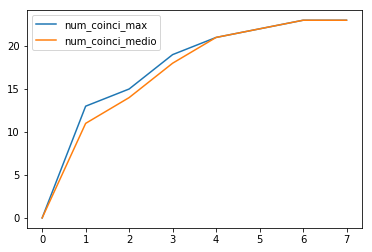

Hay 8 segmentos de información.


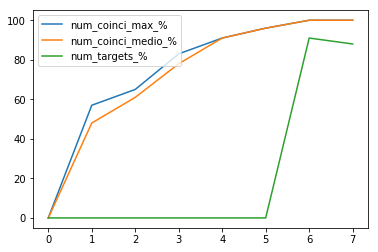

In [828]:
ImprimirGraficas()